# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

## Step 0: Import Pyomo and Pyomo.DOE module

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
#from scipy.interpolate import interp2d
import pandas as pd 
#from itertools import permutations, product, combinations
import idaes

from fim_doe import *

## Step 1: Import Reaction Example Mathematical Model

Consider two chemical reactions that converts molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like do the following perform:

Perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
from reactor_kinetics import *

## Step 2: Define inputs

In [3]:
# Create model function
createmod = create_model

# discretization by Pyomo.DAE
disc = disc_for_measure

# Control time set [h]
t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
# Measurement time points [h]
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Create measurement object
measure_pass = {'C':{'CA': t_measure, 'CB': t_measure, 'CC': t_measure}}
measure_class =  Measurements(measure_pass)

# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

All measurements are flattened.
Flatten measurement name: ['C_index_CA', 'C_index_CB', 'C_index_CC']


In [4]:
def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [5]:
# empty prior
prior_all = np.zeros((4,4))


# add prior information
#prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
#prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

#prior_all = prior_5_300


prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigh(prior_pass)[1])

The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Prior Det: 0.0
Eigenvalue of the prior experiments FIM: [0. 0. 0. 0.]
Eigenvalue of the prior experiments FIM: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## Method: Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [6]:
# choose from 'sequential_finite', 'direct_kaug'
# 'sequential_sipopt', 'sequential_kaug' is also available
sensi_opt = 'sequential_finite'
#sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]
    

# Define experiments
exp1 = generate_exp(t_control, 5, [570, 300, 300, 300, 300, 300, 300, 300, 300])

In [7]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)


result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', 
                                store_output = 'store_output', read_output=None,
                                formula='central')


result.calculate_FIM(doe_object.design_values)


This scenario: {'A1': {0: 84.8756493935153}, 'A2': {0: 371.71773413976416}, 'E1': {0: 7.777032028026428}, 'E2': {0: 15.047135137500822}, 'jac-index': {'A1': [0], 'A2': [0], 'E1': [0], 'E2': [0]}, 'eps-abs': {'A1': 0.0848756493935153, 'A2': 0.37171773413976417, 'E1': 0.007777032028026428, 'E2': 0.015047135137500823}, 'scena-name': [0]}
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/

Output this time:  [5.0, 0.6706243700020834, 0.4195560837359151, 0.2624827180069096, 0.16421446362737377, 0.10273586874285646, 0.06427362421801934, 0.04021087104893356, 0.02515672906555432, 0.0, 1.4356608195123035, 1.5205901724705073, 1.5079974275825079, 1.4413335440984965, 1.347049388125238, 1.241037622436591, 1.1326547091791959, 1.027229845637414, 0.0, 2.8937148104856125, 3.0598537437935778, 3.229519854410583, 3.39445199227413, 3.5502147431319058, 3.69468875334539, 3.8271344197718706, 3.947613425297032]
This scenario: {'A1': {0: 84.79085853498033}, 'A2': {0: 371.71773413976416}, 'E1': {0: 7.784809060054453}, 'E2': {0: 15.047135137500822}, 'jac-index': {'A1': [0], 'A2': [0], 'E1': [0], 'E2': [0]}, 'eps-abs': {'A1': 0.08479085853498033, 'A2': 0.37171773413976417, 'E1': 0.007784809060054453, 'E2': 0.015047135137500823}, 'scena-name': [0]}
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************

Output this time:  [5.0, 0.6706243700020836, 0.4195560837359153, 0.2624827180069097, 0.16421446362737382, 0.10273586874285653, 0.06427362421801941, 0.04021087104893361, 0.02515672906555436, 0.0, 1.441416665040551, 1.5268448073993228, 1.514721262165308, 1.4484455916701346, 1.3544479171661528, 1.248617623361608, 1.1403173456620836, 1.03488709459508, 0.0, 2.887958964957366, 3.0535991088647614, 3.222796019827782, 3.3873399447024912, 3.542816214090991, 3.687108752420372, 3.819471783288983, 3.939956176339366]
This scenario: {'A1': {0: 84.70606767644534}, 'A2': {0: 371.71773413976416}, 'E1': {0: 7.777032028026428}, 'E2': {0: 15.047135137500822}, 'jac-index': {'A1': [0], 'A2': [0], 'E1': [0], 'E2': [0]}, 'eps-abs': {'A1': 0.08470606767644534, 'A2': 0.37171773413976417, 'E1': 0.007777032028026428, 'E2': 0.015047135137500823}, 'scena-name': [0]}
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
T

Output this time:  [5.0, 0.6706243700020837, 0.4195560837359155, 0.26248271800690987, 0.16421446362737402, 0.10273586874285656, 0.06427362421801945, 0.04021087104893362, 0.02515672906555435, 0.0, 1.4384112269396816, 1.5233649787335601, 1.5108005401811877, 1.4441529235617967, 1.3498659292064588, 1.243830257365472, 1.135403210540418, 1.029916244982974, 0.0, 2.890964403058235, 3.0570789375305245, 3.2267167418119023, 3.3916326128108296, 3.547398202050685, 3.691896118416508, 3.8243859184106483, 3.9449270259514715]
This scenario: {'A1': {0: 84.79085853498033}, 'A2': {0: 371.71773413976416}, 'E1': {0: 7.769254995998401}, 'E2': {0: 15.047135137500822}, 'jac-index': {'A1': [0], 'A2': [0], 'E1': [0], 'E2': [0]}, 'eps-abs': {'A1': 0.08479085853498033, 'A2': 0.37171773413976417, 'E1': 0.0077692549959984016, 'E2': 0.015047135137500823}, 'scena-name': [0]}
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


*************************************************************************

Output this time:  [5.0, 0.670624370002084, 0.41955608373591563, 0.2624827180069099, 0.16421446362737396, 0.10273586874285658, 0.06427362421801945, 0.040210871048933616, 0.02515672906555434, 0.0, 1.4326573615440616, 1.5171119900116485, 1.5040785376836843, 1.4370435698520607, 1.342471604700488, 1.2362565062752762, 1.1277492573498347, 1.0222703526130221, 0.0, 2.8967182684538546, 3.0633319262524363, 3.2334387443094053, 3.398741966520566, 3.554792526556655, 3.699469869506704, 3.8320398716012316, 3.9525729183214233]
Build time with sequential_finite mode [s]: 0.04828929901123047
Solve time with sequential_finite mode [s]: 1.1117427349090576
Total wall clock time [s]: 1.8547513484954834
Existed information has been added.
FIM: [[ 2.45738410e-03  5.94863782e-04 -4.56435589e-02 -6.00876165e-02]
 [ 5.94863782e-04  2.22810780e-04 -1.03935357e-02 -2.23273539e-02]
 [-4.56435589e-02 -1.03935357e-02  8.61211473e-01  1.05437230e+00]
 [-6.00876165e-02 -2.23273539e-02  1.05437230e+00  2.27036487e+00]]


In [8]:
mod_eg = doe_object.models[0]

t_list = []
for t in mod_eg.t:
    t_list.append(t)
    
print('kp1:')
for i in t_list:
    print(value(mod_eg.kp1[0,i]))
    
print('kp2:')
for i in t_list:
    print(value(mod_eg.kp2[0,i]))
    
print('CA:')
for i in t_list:
    print(value(mod_eg.C[0,'CA',i]))
    
print('CB:')
for i in t_list:
    print(value(mod_eg.C[0,'CB',i]))
    
print('CC:')
for i in t_list:
    print(value(mod_eg.C[0,'CC',i]))

kp1:
16.447958186505904
16.447958186505904
16.447958186505904
16.447958186505904
16.447958186505904
16.447958186505904
16.447958186505904
16.447958186505904
16.447958186505904
16.447958186505904
16.447958186505904
16.447958186505904
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.7558478281198764
3.75584

In [9]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 0.49613453997436285
D-optimality: -10.3118203437022
E-optimality: -5.553641798357302
Modified E-optimality: 6.006360465080967


## Method: Optimization
Gradient-based optimization with IPOPT with .optimize_doe()

This function solves twice: It solves the square version of the MBDoE problem firstly, and then unfixes the design variables as Degree of Freedoms and solves again. In this way the optimization problem can be well initialized. 

In [10]:
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])
#exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])

In [11]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=[True])

square_result, optimize_result= doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, 
                                                         scale_nominal_param_value=True, objective_option='det', 
                                                         L_initial=None)


Sensitivity information is scaled by its corresponding parameter nominal value.
    'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2

 100r-1.2887888e+01 1.83e+00 1.46e+03  -5.4 1.29e+02    -  4.58e-02 2.15e-03f  1
 101r-1.2887917e+01 1.83e+00 1.62e+03  -5.4 1.29e+02    -  7.67e-01 5.79e-06h  1
 102r-1.4308409e+01 4.22e+00 1.10e+03  -5.4 1.29e+02    -  3.49e-01 3.25e-01f  1
 103r-1.4315262e+01 4.21e+00 8.85e+02  -5.4 1.10e+02    -  3.73e-01 2.15e-03h  1
 104r-1.4318443e+01 4.20e+00 8.66e+02  -5.4 1.10e+02    -  3.37e-01 1.08e-03h  1
 105r-1.5058284e+01 4.23e+00 6.57e+02  -5.4 1.10e+02    -  2.16e-01 2.59e-01f  1
 106r-1.5058585e+01 4.23e+00 8.34e+02  -5.4 9.32e+01    -  5.00e-01 1.79e-04h  1
 107r-1.6351538e+01 7.24e+00 1.40e+03  -5.4 9.32e+01    -  3.02e-01 7.94e-01f  1
 108r-1.6352414e+01 7.21e+00 1.46e+03  -5.4 3.14e+01    -  1.00e+00 4.20e-03h  1
 109r-1.6420334e+01 4.92e+00 1.12e+03  -5.4 3.00e+01    -  1.01e-01 3.26e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r-1.6420512e+01 4.91e+00 1.27e+03  -5.4 2.03e+01    -  8.01e-01 1.36e-03h  1
 111r-1.6554050e+01 2.66e-01

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

  67 -6.8577374e+00 4.05e+04 9.77e+08  -1.0 7.39e+02   4.3 1.00e+00 1.93e-03h  1
  68 -6.8455275e+00 3.90e+04 9.42e+08  -1.0 3.88e+02   4.7 8.15e-01 3.60e-02h  1
  69 -6.6232786e+00 3.51e+04 8.42e+08  -1.0 8.14e+02   4.3 1.00e+00 1.07e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -6.5229725e+00 3.02e+04 7.22e+08  -1.0 3.82e+02   4.7 4.46e-01 1.42e-01h  1
Reallocating memory for MA57: lfact (403519)
  71 -6.4572429e+00 3.10e+04 7.12e+08  -1.0 1.05e+03   4.2 2.29e-03 1.42e-02h  4
  72 -6.2546638e+00 2.59e+04 5.84e+08  -1.0 3.81e+02   4.6 1.00e+00 1.80e-01h  1
Reallocating memory for MA57: lfact (431923)
  73 -6.2465438e+00 2.59e+04 5.84e+08  -1.0 1.44e+04   4.2 2.94e-02 1.11e-04h  5
  74 -6.1790084e+00 2.48e+04 5.57e+08  -1.0 3.81e+02   4.6 5.89e-01 4.50e-02h  1
  75 -6.1316408e+00 2.37e+04 5.26e+08  -1.0 1.87e+02   5.0 2.33e-01 5.67e-02h  1
  76 -6.0937052e+00 2.36e+04 5.12e+08  -1.0 3.88e+02   4.5 6.69e-02 2.59e-02h  2
  77 -6.0723169e+00

 159 -9.3266977e+00 1.02e+01 4.15e+06  -1.0 3.50e+00   6.1 1.00e+00 2.93e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -9.3257922e+00 1.02e+01 4.15e+06  -1.0 9.26e+00   5.6 1.00e+00 1.17e-02h  6
 161 -9.3269517e+00 1.02e+01 4.14e+06  -1.0 2.04e+01   5.2 1.00e+00 3.11e-03h  8
 162 -9.3257460e+00 1.02e+01 4.14e+06  -1.0 1.01e+01   5.6 1.00e+00 1.54e-02h  7
 163 -9.3278135e+00 1.02e+01 4.13e+06  -1.0 2.17e+01   5.1 1.00e+00 3.07e-03h  8
 164 -9.3254141e+00 1.02e+01 4.12e+06  -1.0 1.11e+01   5.5 1.00e+00 3.12e-02h  6
 165 -9.3293018e+00 1.02e+01 4.12e+06  -1.0 2.29e+01   5.0 1.00e+00 3.02e-03h  8
 166 -9.2772994e+00 3.16e+02 3.84e+06  -1.0 1.20e+01   5.5 1.00e+00 5.00e-01h  2
 167 -1.0264601e+01 2.45e+02 3.22e+06  -1.0 1.95e+01   5.0 9.25e-01 3.28e-01h  1
 168 -1.0256458e+01 2.32e+02 3.14e+06  -1.0 7.19e+00   5.4 1.00e+00 5.61e-02h  2
 169 -1.0918806e+01 2.10e+02 2.88e+06  -1.0 1.67e+01   4.9 7.36e-01 1.25e-01h  1
iter    objective    inf_pr 

 252r 1.2891516e+01 2.61e+05 1.00e+03   4.4 0.00e+00   0.4 0.00e+00 3.09e-07R  5
 253r-5.9348879e+00 2.48e+05 1.00e+03   4.4 2.26e+07    -  1.28e-04 2.41e-04f  1
 254 -6.0885709e+00 2.18e+05 1.09e+04  -1.0 2.97e+05    -  3.27e-01 1.67e-01h  2
 255 -6.0839062e+00 2.05e+05 2.04e+04  -1.0 3.98e+05    -  5.69e-01 1.14e-01h  2
 256 -6.1598479e+00 1.86e+05 1.95e+04  -1.0 2.78e+05    -  3.85e-01 1.34e-01h  2
 257 -6.0928501e+00 1.86e+05 1.94e+04  -1.0 1.43e+03  -0.1 4.64e-03 4.53e-04h  1
 258 -6.1131934e+00 1.10e+05 2.93e+05  -1.0 1.42e+05    -  3.89e-02 6.41e-01H  1
 259 -6.0822574e+00 9.31e+04 2.47e+05  -1.0 3.72e+04    -  3.92e-01 1.58e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -6.1373868e+00 9.09e+04 2.41e+05  -1.0 3.18e+04    -  6.96e-01 2.37e-02h  4
 261 -6.1515161e+00 8.99e+04 2.38e+05  -1.0 3.11e+04    -  2.66e-01 1.03e-02h  5
 262 -6.1550192e+00 8.97e+04 2.38e+05  -1.0 3.08e+04    -  8.32e-01 2.42e-03h  7
 263 -6.1553433e+00 8.97e+04

 347 -1.6546696e+01 5.30e+04 2.26e+07  -1.0 9.52e+03   0.2 1.53e-02 4.85e-03h  1
 348 -1.6910884e+01 5.26e+04 2.24e+07  -1.0 1.04e+04  -0.3 3.28e-02 7.26e-03h  3
 349 -1.7248839e+01 5.21e+04 2.22e+07  -1.0 1.11e+04  -0.8 7.73e-01 8.71e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -1.8322671e+01 5.09e+04 2.16e+07  -1.0 1.18e+04  -1.3 9.27e-02 2.48e-02h  4
 351 -1.9393762e+01 4.94e+04 3.45e+07  -1.0 2.05e+04  -1.7 1.38e-01 4.33e-02h  4
 352 -1.9674631e+01 4.48e+04 3.04e+07  -1.0 1.43e+04    -  4.12e-01 5.72e-02H  1
 353 -1.9673417e+01 4.48e+04 3.04e+07  -1.0 1.40e+04    -  2.42e-01 3.89e-04H  1
 354 -1.9830629e+01 4.38e+04 3.04e+07  -1.0 1.56e+04    -  2.42e-03 2.24e-02h  1
 355 -1.9840518e+01 4.37e+04 3.04e+07  -1.0 1.41e+04    -  2.37e-03 1.71e-03h  1
 356 -1.9961835e+01 4.28e+04 3.02e+07  -1.0 1.42e+04    -  2.17e-02 2.28e-02h  1
 357 -1.9956973e+01 4.25e+04 3.01e+07  -1.0 1.42e+04    -  5.16e-01 2.66e-03H  1
 358 -2.0341814e+01 3.47e+04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440 -3.5878653e+01 2.20e+03 3.54e+02  -1.0 8.11e+06    -  2.28e-03 2.19e-03h  3
 441 -3.5795422e+01 5.40e+00 3.19e+00  -1.0 1.67e+02  -6.8 1.00e+00 1.00e+00h  1
 442 -3.5820237e+01 3.33e+00 8.89e-01  -1.0 3.81e+02  -7.3 1.00e+00 1.00e+00h  1
 443 -3.5856416e+01 7.45e+00 1.53e+00  -1.0 6.50e+02  -7.8 1.00e+00 1.00e+00h  1
 444 -3.5883859e+01 5.10e+00 5.54e+00  -1.0 7.35e+02  -8.2 1.00e+00 1.00e+00h  1
 445 -3.5959562e+01 1.99e+01 2.19e+01  -1.0 4.14e+03  -8.7 1.00e+00 1.00e+00H  1
 446 -3.6239607e+01 3.80e+03 8.76e+00  -1.0 1.22e+05    -  1.00e+00 1.00e+00h  1
 447 -3.6238078e+01 4.32e+00 2.61e-01  -1.0 2.29e+03    -  1.00e+00 1.00e+00h  1
 448 -3.6237588e+01 2.54e-03 7.05e-04  -1.0 6.62e+01    -  1.00e+00 1.00e+00h  1
 449 -3.6585982e+01 3.55e+03 9.17e+00  -2.5 1.02e+05    -  8.90e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450 -3.7308164e+01 2.78e+04

======Result summary======
This optimization is solved with status: converged
The result FIM is: [[  17.22555319   14.38327267  -36.46377848  -71.12350849]
 [  14.38327267   34.96951119  -27.34621973 -169.60206531]
 [ -36.46377848  -27.34621973   78.37662971  136.01316283]
 [ -71.12350849 -169.60206531  136.01316283  829.48814055]]
Four design criteria log10() value:
A-optimality: 2.982298300790362
D-optimality: 3.3031906052446085
E-optimality: -0.9184299903527576
Modified E-optimality: 3.8701719689123917
477.1345185403312
300.00007331370665



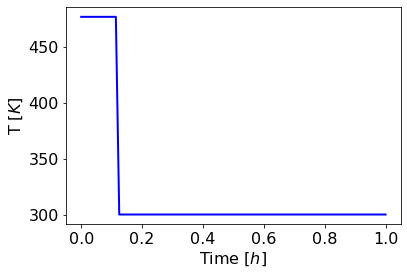

In [12]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('The result FIM is:', optimize_result.FIM)
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(optimize_result.trace))
print('D-optimality:', np.log10(optimize_result.det))
print('E-optimality:', np.log10(optimize_result.min_eig))
print('Modified E-optimality:', np.log10(optimize_result.cond))

t_list = []
for t in optimize_result.model.t:
    t_list.append(t)

T_list = []
for i in t_list:
    T_list.append(value(optimize_result.model.T[i]))

print(value(optimize_result.model.T[0]))
print(value(optimize_result.model.T[1]))
print()
    
si=16
plt.rc('axes', titlesize=si)
plt.rc('axes', labelsize=si)
plt.rc('xtick', labelsize=si)
plt.rc('ytick', labelsize=si)
plt.rc('legend', fontsize=12)
    
plt.plot(t_list, T_list, 'b', linewidth=2)
#plt.scatter(t_list, T_list, 'b')
plt.ylabel('T [$K$]')
plt.xlabel('Time [$h$]')
plt.show()

## Method: Exploratory analysis (Enumeration)

This method conducts exploratory analysis by enumeration. 
It allows to define any number (dimensions) of design variables.
Heatmaps can be drawn by two design variables, fixing other design variables; 
1D curve can be drawn by one design variable, fixing other design variables.

### Specify user inputs

In [ ]:
# Design variable ranges as lists 
design_ranges = [list(np.linspace(1,5,5)), list(np.linspace(300,700,5))]

# Design variable names 
dv_apply_name = ['CA0','T']

# Design variable should be fixed at these time points
dv_apply_time = [[0],t_control]

# Define experiments. This is a starting point of which the value does not matter
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])
    
## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

In [ ]:
# add prior information
prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
#prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

prior_all = prior_5_300

prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)

all_fim = doe_object.run_grid_search(exp1, design_ranges, dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt)

### 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

In [ ]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [ ]:

# Define design ranges
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

# Define design variable 
# Here the two T are for different controlling time subsets
dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])

## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)

all_fim = doe_object.run_grid_search(exp1, design_ranges, dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt)

### Draw 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

In [ ]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )